In [1]:
%load_ext autoreload
%autoreload

In [2]:
import h5py, os, tqdm, glob
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import jax
# jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax_cosmo as jc

import optax
from flax import nnx
import orbax.checkpoint as ocp

import diffrax
from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

import jaxpm
from jaxpm.painting import cic_paint, cic_read
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces, make_ode_fn_diffrax
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.nn import MLP

# configuration

In [26]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

# initial conditions

### LPT

In [4]:
# def get_initial_displacements(omega_c, sigma8):
#     # Create a small function to generate the matter power spectrum
#     k = jnp.logspace(-4, 1, 128)
#     pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
#     pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    
#     # Create initial conditions
#     initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))
    
#     # Create particles
#     particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]), axis=-1).reshape([-1,3])
    
#     cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
#     # Initial displacement
#     dx, p, _ = lpt(cosmo, initial_conditions, particles, 0.1)

#     return particles + dx, p, cosmo

# pos_i, vel_i, cosmo = get_initial_displacements(0.25, 0.8)
# scales = jnp.linspace(0.1,1.,16)

### CAMELS

In [56]:
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"

SNAPSHOTS = glob.glob(os.path.join(SIM, "snapshot_???.hdf5"))
SNAPSHOTS.sort()

# SNAPSHOTS = [SNAPSHOTS[0]]
SNAPSHOTS = [SNAPSHOTS[0], SNAPSHOTS[-1]]

# only consider gas particles that exist for all snapshots
for i, SNAPSHOT in tqdm.tqdm(enumerate(SNAPSHOTS), total=len(SNAPSHOTS), desc="finding unique gas particle indices"):
    with h5py.File(SNAPSHOT, "r") as data:        
        gas_ids = data['PartType0/ParticleIDs'][:]
        dm_ids = data['PartType1/ParticleIDs'][:]
        
    if i == 0:
        gas_ids_intersect = gas_ids        
    else:
        gas_ids_intersect = np.intersect1d(gas_ids_intersect, gas_ids)

# randomly subselect particles
rng = np.random.default_rng(7)
dm_sub_ids = rng.choice(dm_ids, parts_per_dim**3, replace=False)
gas_sub_ids = rng.choice(gas_ids_intersect, parts_per_dim**3, replace=False)

scales = []

dm_poss = []
dm_vels = []

gas_poss = []
gas_vels = []
gas_ms = []
for i, SNAPSHOT in tqdm.tqdm(enumerate(SNAPSHOTS), total=len(SNAPSHOTS), desc="loading snapshots"):
    with h5py.File(SNAPSHOT, "r") as data:
        if i == 0:
            # all of these should be constant
            box_size     = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
            scale_factor = data['Header'].attrs[u'Time']           #scale factor
            h            = data['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
            masses       = data['Header'].attrs[u'MassTable']*1e10 #masses of the particles in Msun/h
            Omega_m      = data['Header'].attrs[u'Omega0']
            Omega_L      = data['Header'].attrs[u'OmegaLambda']
            Omega_b      = data['Header'].attrs[u'OmegaBaryon']
        
        redshift = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
        scales.append((1./(1+redshift)))
        
        # dark matter particles
        dm_mask = np.isin(data['PartType1/ParticleIDs'][:], dm_sub_ids)
        dm_pos = data['PartType1/Coordinates'][:][dm_mask]/1e3  #Mpc/h
        dm_pos *= mesh_per_dim / box_size  #Rescaling positions to grid coordinates
        dm_vel = data['PartType1/Coordinates'][:][dm_mask]  #peculiar velocities in km/s
        dm_vel *= mesh_per_dim * (1./(1+redshift)) / (box_size * 100)

        dm_poss.append(dm_pos)
        dm_vels.append(dm_vel)

        # gas particles      
        gas_mask = np.isin(data['PartType0/ParticleIDs'][:], gas_sub_ids)
        
        gas_pos  = data['PartType0/Coordinates'][:][gas_mask]/1e3 #Mpc/h
        gas_pos *= mesh_per_dim / box_size  #Rescaling positions to grid coordinates
        gas_vel = data['PartType0/Coordinates'][:][gas_mask]  #peculiar velocities in km/s
        gas_vel *= mesh_per_dim * (1./(1+redshift)) / (box_size * 100)

        gas_poss.append(gas_pos)
        gas_vels.append(gas_vel)
        
        gas_mass = data['PartType0/Masses'][:][gas_mask]*1e10     #Msun/h 
        gas_ms.append(gas_mass)
        # gas_rho = data['/PartType0/Density'][:][gas_mask]*1e10 * (1e3)**3 #(Msun/h)/(Mpc/h)^3
        # gas_U   = data['/PartType0/InternalEnergy'][:][gas_mask]  #(km/s)^2
        # gas_ne  = data['/PartType0/ElectronAbundance'][:][gas_mask]
        # # Derive pressure
        # gamma = 5.0/3.0
        # gas_P = (gamma-1.0)*hydro_gas_U*hydro_gas_rho #units are (Msun/h)*(km/s)^2/(Mpc/h)^3
        # # And temperature
        # yhelium = 0.0789
        # BOLTZMANN  = 1.38065e-16         #erg/K - NIST 2010
        # PROTONMASS = 1.67262178e-24      #gram  - NIST 2010
        # gas_T = hydro_gas_U*(1.0 + 4.0*yhelium)/(1.0 + yhelium + hydro_gas_ne)*1e10*(2.0/3.0)
        # gas_T *= (PROTONMASS/BOLTZMANN)
        # gas_poss.append(gas_pos)

scales = jnp.array(scales)
dm_pos_i = dm_poss[0]
dm_vel_i = dm_vels[0]
gas_pos_i = gas_poss[0]
gas_vel_i = gas_vels[0]

loading snapshots:   0%|          | 0/2 [00:00<?, ?it/s]

25.0


loading snapshots:  50%|█████     | 1/2 [00:03<00:03,  3.63s/it]

25.0


loading snapshots: 100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


In [63]:
(gas_mass/masses[1]).mean()

0.20097849

In [64]:
Omega_m

0.3

In [65]:
Omega_b

0.049

In [67]:
Omega_b/(Omega_m - Omega_b)

0.1952191235059761

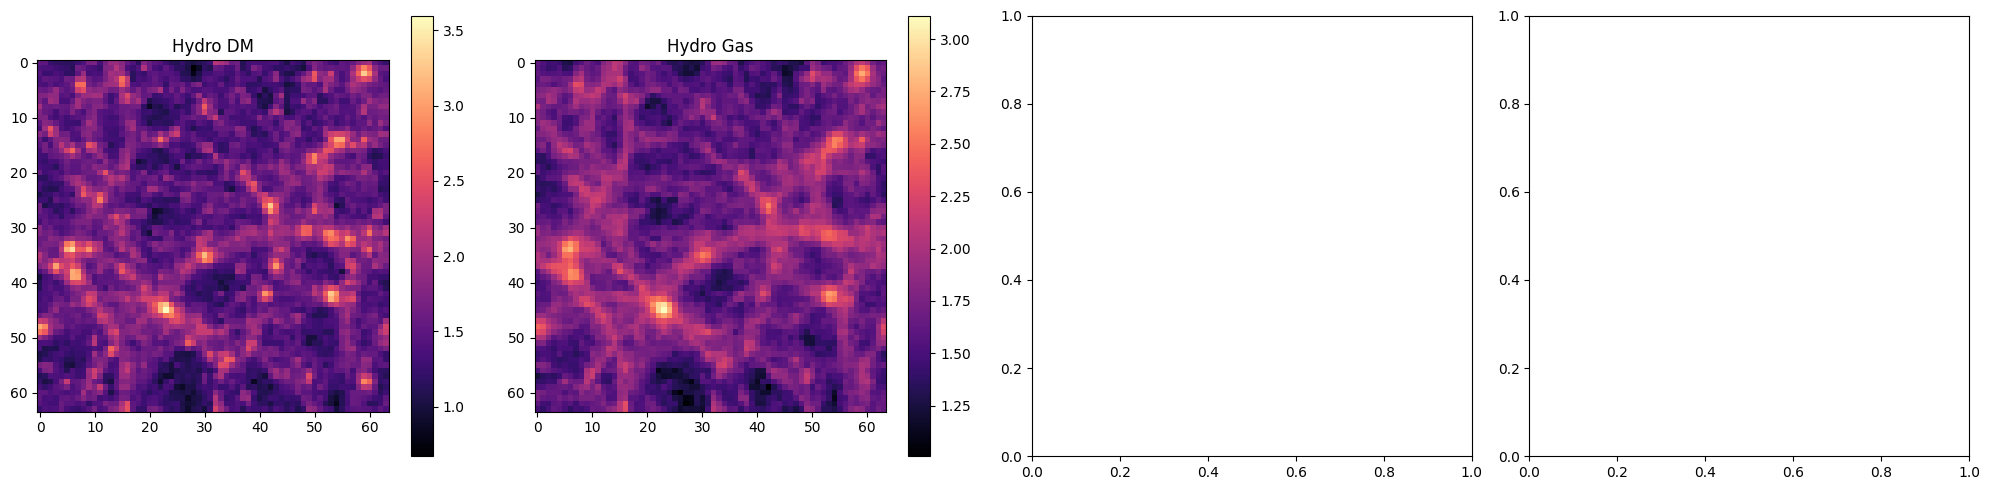

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

im0 = ax[0].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), dm_pos).sum(axis=0)), cmap='magma')
ax[0].set(title='Hydro DM')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), gas_pos).sum(axis=0)), cmap='magma')
ax[1].set(title='Hydro Gas')
fig.colorbar(im1, ax=ax[1])

# im2 = ax[2].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos, hydro_gas_P/hydro_gas_rho).sum(axis=0)), cmap='magma')
# ax[2].set(title='Hydro Gas Pressure')
# fig.colorbar(im2, ax=ax[2])

# im3 = ax[3].imshow(np.log10(cic_paint(jnp.zeros(mesh_shape), hydro_gas_pos, hydro_gas_T/hydro_gas_rho).sum(axis=0)), cmap='magma')
# ax[3].set(title='Hydro Gas Temperature')
# fig.colorbar(im3, ax=ax[3])

fig.tight_layout()

### ODE solver

In [5]:
@partial(jax.jit, static_argnums=[0, 5, 6, 7])
def run_simulation(ode_fun, pos, vel, scales, cosmo, checkpoints=5, rtol=1e-5, atol=1e-5):
    print("tracing the simulation")
        
    res = diffeqsolve(
        terms=ODETerm(ode_fun),
        solver=Dopri5(),
        t0=scales[0],
        t1=scales[-1],
        dt0=0.05,
        y0=jnp.stack([pos_i, vel_i], axis=0),
        saveat=SaveAt(ts=scales),
        adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints),
        max_steps=100,
        stepsize_controller=PIDController(rtol=rtol, atol=atol),
    )

    return res.ts, res.ys[:,0], res.ys[:,1]

# reference simulation

tracing the simulation


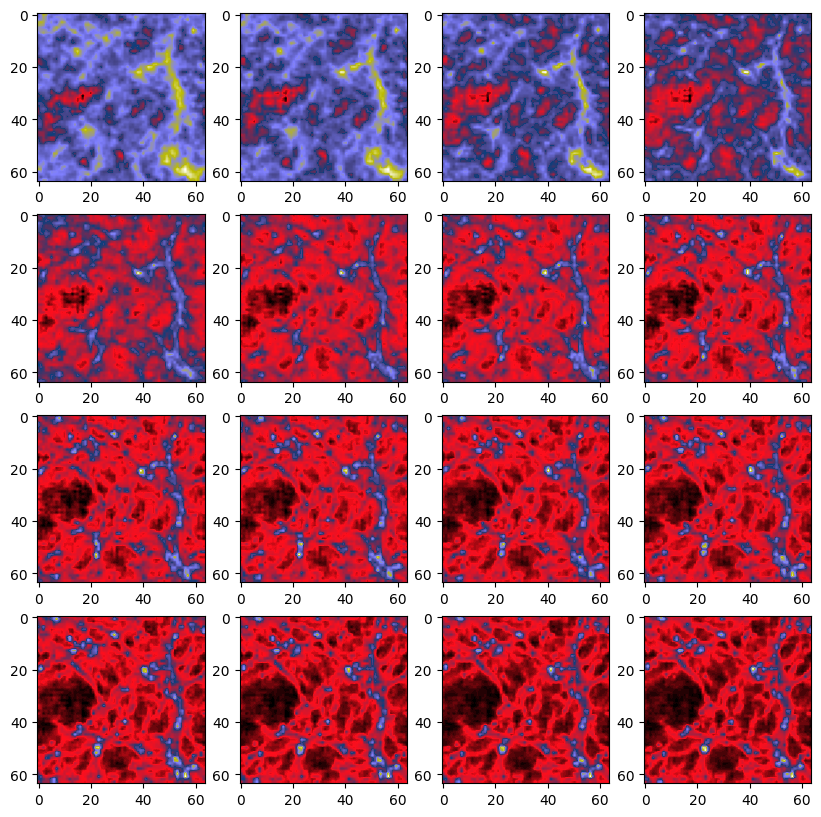

In [8]:
reference_ode = make_ode_fn_diffrax(cosmo, mesh_shape)

ts, poss, vels = run_simulation(
    reference_ode,
    pos_i, 
    vel_i, 
    scales, 
    cosmo
)

plt.figure(figsize=[10,10])
for i in range(16):
    plt.subplot(4,4,i+1)
    im = plt.imshow(
        cic_paint(jnp.zeros(mesh_shape), poss[i]).sum(axis=0), 
        cmap='gist_stern',
        vmin=0,
        # vmax=cic_paint(jnp.zeros(mesh_shape), pos_i).sum(axis=0).max(),
    )

In [7]:
%%timeit
ts, poss, vels = run_simulation(
    reference_ode,
    pos_i, 
    vel_i, 
    scales, 
    cosmo
)

186 ms ± 64.3 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# HPM simulation

In [14]:
model = MLP(
    d_in=2, 
    d_out=2, 
    d_hidden=512, 
    n_hidden=4, 
    rngs=nnx.Rngs(0)
)

abstract_model = nnx.eval_shape(lambda: model)
graphdef, abstract_params = nnx.split(abstract_model)

checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp")
checkpointer = ocp.StandardCheckpointer()
params = checkpointer.restore(checkpoint_file, abstract_params)
model = nnx.merge(graphdef, params)

/cluster/home/athomsen/flatiron/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [ ]:
Omega_b/(Omega_m - Omega_b)

In [72]:
delta_tot_1 = cic_paint(jnp.zeros(mesh_shape), dm_pos)
delta_tot_1 = cic_paint(delta_tot_1, gas_pos)
delta_tot_1[:3,:3,:3]

Array([[[0.28154966, 0.26230767, 0.5349207 ],
        [1.5725002 , 0.16033193, 0.25272053],
        [1.0206747 , 0.6433382 , 0.51809484]],

       [[0.00566889, 0.41365254, 0.28989047],
        [0.10706828, 0.244629  , 0.2961457 ],
        [0.38563612, 0.69785017, 0.15608545]],

       [[0.06707522, 0.1045327 , 0.5306937 ],
        [0.0396757 , 0.09123751, 1.1379747 ],
        [0.20451167, 0.50158226, 0.45054406]]], dtype=float32)

In [ ]:
delta_tot_1 = cic_paint(jnp.zeros(mesh_shape), dm_pos)
delta_tot_1 = cic_paint(delta_tot_1, gas_pos)
delta_tot_1[:3,:3,:3]

In [68]:
dm_pos_i

array([[11.724611  ,  3.3293614 , 57.66407   ],
       [11.767946  ,  3.3328028 , 57.617805  ],
       [11.75252   ,  3.3315036 , 57.649918  ],
       ...,
       [ 0.69702846, 63.96046   , 50.981674  ],
       [ 1.1342884 ,  0.58220154, 55.239548  ],
       [ 1.6672423 ,  0.18624635, 62.56739   ]], dtype=float32)

In [ ]:
def hpm_forces(dm_pos, gas_pos, mesh_shape, r_split=0):
    delta_tot = cic_paint(jnp.zeros(mesh_shape), dm_pos)
    # TODO is this uniform weighting reasonable?
    delta_tot = cic_paint(delta_tot, gas_pos, weight=Omega_b/(Omega_m - Omega_b))
    
    # gravitational potential
    kvec = fftk(mesh_shape)
    delta_k = jnp.fft.rfftn(delta_tot)
    pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec, r_split=r_split)

    # pressure force
    
    # Computes gravitational forces
    return jnp.stack(
        [cic_read(jnp.fft.irfftn(-gradient_kernel(kvec, i) * pot_k), positions) for i in range(len(kvec))],
        axis=-1,
    )

In [9]:
def nbody_ode(a, state, args):
    pos, vel = state
    forces = pm_forces(pos, mesh_shape) * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1.0 / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel

    # Computes the update of velocity (kick)
    dvel = 1.0 / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces

    return jnp.stack([dpos, dvel])